# 미션 소개

텍스트 데이터와 임베딩 토픽에서 배운 내용을 바탕으로 문제 풀기

## 사용 데이터 셋
18,846개의 뉴스 문서를 20개의 카테고리로 분류한 News Group 20 데이터를 사용한다.

텍스트 데이터를 입력으로 받아 뉴스의 카테고리를 예측하는 딥 러닝 모델을 구현.

## 가이드라인
- 데이터 전처리
    - 텍스트 데이터에서 토큰화를 수행
    - 데이터를 훈련 세트와 테스트 세트로 적절히 분리

- 임베딩 적용
    - Word2Vec, FastText, GloVe 방식으로 입력 데이터를 벡터화하여 임베딩 행렬을 생성
- 데이터셋 및 로더 구현
    - PyTorch의 Dataset과 DataLoader 객체를 활용해 데이터를 처리할 수 있도록 구현
    - 벡터화된 데이터를 모델에 입력 가능한 형태로 변환
- 모델 구현
    - LSTM, GRU 등 RNN 기반의 딥러닝 모델을 구현
    - 임베딩 레이어를 추가해 입력 데이터와 임베딩 벡터를 연결
    - 각 임베딩 방식(Word2Vec, FastText, GloVe)에 대해 모델을 학습할 수 있도록 설정
- 모델 학습 및 평가
    - 모델을 학습시키고, 테스트 데이터에서 정확도 등 주요 평가지표를 계산
    - Word2Vec, FastText, GloVe 임베딩 방식을 사용했을 때의 성능을 비교하고 결과를 분석
- 모델 성능 개선 (심화)
    - 데이터 전처리(특수 문자, 불용어 제거 등) 및 모델 구조 변경, 하이퍼파라미터 튜닝 등을 통해 모델의 성능을 높히기

# 환경 설정

In [1]:
!pip install gensim

In [2]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader

from gensim.models import Word2Vec, FastText
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

## GPU 세팅

In [3]:
"""
print("PyTorch:", torch.__version__)
print("MPS available:", torch.backends.mps.is_available())
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)
"""

'\nprint("PyTorch:", torch.__version__)\nprint("MPS available:", torch.backends.mps.is_available())\ndevice = torch.device("mps" if torch.backends.mps.is_available() else "cpu")\nprint(device)\n'

In [4]:
# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 한국어 세팅

In [5]:
# Install Korean font for matplotlib
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (5,187 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126284 files and dire

In [6]:
"""
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Configure matplotlib for Korean characters
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False # Allow negative signs in plots
"""

"\nimport matplotlib.pyplot as plt\nimport matplotlib.font_manager as fm\n\n# Configure matplotlib for Korean characters\nplt.rc('font', family='NanumBarunGothic')\nplt.rcParams['axes.unicode_minus'] = False # Allow negative signs in plots\n"

In [7]:
import matplotlib.pyplot as plt
import platform
import os
import matplotlib.font_manager as fm

# Configure matplotlib for Korean characters
if platform.system() == 'Darwin': # macOS
    path = '/System/Library/Fonts/Supplemental/Arial Unicode MS.ttf'
    if not os.path.exists(path):
        path = '/System/Library/Fonts/Helvetica.ttc'
else: # Linux
    path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

try:
    fm.fontManager.addfont(path)
    plt.rc('font', family=fm.FontProperties(fname=path, size=10).get_name())
except:
    # Fallback to default font if NanumGothic cannot be found/used
    plt.rc('font', family='DejaVu Sans')


plt.rcParams['axes.unicode_minus'] = False # Allow negative signs in plots


# 데이터

## NLTK

In [8]:
# NLTK 데이터를 현재 폴더의 nltk_data 디렉토리에 다운로드
current_dir = os.getcwd()
nltk_data_dir = os.path.join(current_dir, 'nltk_data')
nltk.data.path.append(nltk_data_dir)

print(f"NLTK 데이터 경로: {nltk_data_dir}")
print(f"경로 존재 여부: {os.path.exists(nltk_data_dir)}")

nltk.download('punkt', download_dir=nltk_data_dir)
nltk.download('punkt_tab', download_dir=nltk_data_dir)
nltk.download('stopwords', download_dir=nltk_data_dir)
nltk.download('wordnet', download_dir=nltk_data_dir)
nltk.download('omw-1.4', download_dir=nltk_data_dir)
nltk.download('averaged_perceptron_tagger_eng', download_dir=nltk_data_dir)

NLTK 데이터 경로: /content/nltk_data
경로 존재 여부: False


[nltk_data] Downloading package punkt to /content/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /content/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /content/nltk_data...
[nltk_data] Downloading package omw-1.4 to /content/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /content/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

## 데이터셋 불러오기

In [9]:
from sklearn.datasets import fetch_20newsgroups

# 훈련 데이터와 테스트 데이터를 모두 가져옴
# news_data_raw는 data, target으로 구성됨
news_data_raw = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
texts = news_data_raw.data     # 문서 내용
labels = news_data_raw.target  # 레이블
target_names = news_data_raw.target_names
len(texts), len(target_names)

(18846, 20)

In [10]:
print(f"Number of documents: {len(texts)}")
print(f"Sample document: \n{texts[0]}")
print(f"Unique labels: {set(labels)}")
id2label = {i: name for i, name in enumerate(target_names)}
print("Target names:")
for i in range(len(target_names)):
    print(f"{i} -> {target_names[i]}")

Number of documents: 18846
Sample document: 


I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a lot of
fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final
regular season game.          PENS RULE!!!


Unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
Target names:
0 -> alt.atheism
1 -> comp.graphics
2 -> comp.os.ms-windows.misc
3 -> comp.sys.ibm.pc.hardware
4 -> comp.sys.mac.hardware
5 -> comp.windows.x


## 데이터 전처리

불용어(Stopword) 제거 및 표제어 추출(Lemmatization)

In [11]:
# 보존할 기호
ALLOWED_SYMBOLS = "+-_#"
# 정규식 패턴 (허용 문자 외는 공백으로 치환)
_CLEAN_PATTERN = re.compile(rf"[^a-z0-9{re.escape(ALLOWED_SYMBOLS)}\s]")
# 공백 정리
_SPACES = re.compile(r"\s+")
# 불용어 제거
_BASE_STOPS = set(stopwords.words('english'))
# 표제어 추출(Lemmatization)
lemm = WordNetLemmatizer()
# 토큰화
tokenizer = RegexpTokenizer(rf"[a-z0-9{re.escape(ALLOWED_SYMBOLS)}]+")

#--------------------------------

# 불용어 제거 함수
def build_stopwords(keep_negation=True):
    sw = set(_BASE_STOPS)
    if keep_negation:
        sw -= {'not', 'no'}
    return sw

def to_wordnet_pos(treebank_tag: str):
    """NLTK POS → WordNet POS 매핑"""
    if treebank_tag.startswith("J"): return wordnet.ADJ
    if treebank_tag.startswith("V"): return wordnet.VERB
    if treebank_tag.startswith("N"): return wordnet.NOUN
    if treebank_tag.startswith("R"): return wordnet.ADV
    return wordnet.NOUN  # 기본값

def clean_text(s: str):
    """소문자화 + (허용 외)문자 제거 + 공백 정리. 숫자/일부 기호 보존."""
    s = s.lower()
    s = _CLEAN_PATTERN.sub(" ", s)
    s = _SPACES.sub(" ", s).strip()
    return s

def tokenize_pos_lemmatize(s: str, stop_en=None):
    """
    1) 정제 → 2) 정규식 토큰화(허용된 기호 포함) → 3) 불용어 제거 → 4) POS 태깅 → 5) 표제어화
    - c++, x11 같은 토큰 보존
    - 비알파벳 혼합 토큰(예: c++, x11)은 의미 보존 위해 lemmatize 건너뜀
    """

    if stop_en is None:
        stop_en = build_stopwords(keep_negation=True)

    s = clean_text(s)
    tokens = tokenizer.tokenize(s)
    tokens = [t for t in tokens if t not in stop_en]

    # 품사 태깅
    tagged = nltk.pos_tag(tokens)

    # 표제어화
    # 품사별 표제어화 매핑
    lemmas = []
    for w, t in tagged:
        if w.isalpha():  # 전부 알파벳인 경우만 표제어화(기호/숫자 포함 토큰은 원형 유지)
            lemmas.append(lemm.lemmatize(w, pos=to_wordnet_pos(t)))
        else:
            lemmas.append(w)
    return lemmas


def preprocess_corpus(texts, keep_negation=True, show_progress=True):
    """
    코퍼스 단위 전처리. 토큰 리스트들의 리스트 반환.
    """
    stop_en = build_stopwords(keep_negation=keep_negation)
    it = tqdm(texts, desc="Preprocess") if show_progress else texts
    return [tokenize_pos_lemmatize(s, stop_en=stop_en) for s in it]


# 전체 코퍼스 전처리
tokenized = preprocess_corpus(texts, keep_negation=True)

Preprocess: 100%|██████████| 18846/18846 [01:49<00:00, 172.40it/s]


In [12]:
tokenized

[['sure',
  'bashers',
  'pen',
  'fan',
  'pretty',
  'confused',
  'lack',
  'kind',
  'post',
  'recent',
  'pen',
  'massacre',
  'devil',
  'actually',
  'bit',
  'puzzled',
  'bit',
  'relieve',
  'however',
  'go',
  'put',
  'end',
  'non-pittsburghers',
  'relief',
  'bit',
  'praise',
  'pen',
  'man',
  'kill',
  'devil',
  'bad',
  'think',
  'jagr',
  'show',
  'much',
  'good',
  'regular',
  'season',
  'stats',
  'also',
  'lot',
  'fo',
  'fun',
  'watch',
  'playoff',
  'bowman',
  'let',
  'jagr',
  'lot',
  'fun',
  'next',
  'couple',
  'game',
  'since',
  'pen',
  'go',
  'beat',
  'pulp',
  'jersey',
  'anyway',
  'disappointed',
  'not',
  'see',
  'islander',
  'lose',
  'final',
  'regular',
  'season',
  'game',
  'pen',
  'rule'],
 ['brother',
  'market',
  'high-performance',
  'video',
  'card',
  'support',
  'vesa',
  'local',
  'bus',
  '1-2mb',
  'ram',
  'anyone',
  'suggestion',
  'ideas',
  '-',
  'diamond',
  'stealth',
  'pro',
  'local',
  'bus'

데이터 분할 (Train / Test)

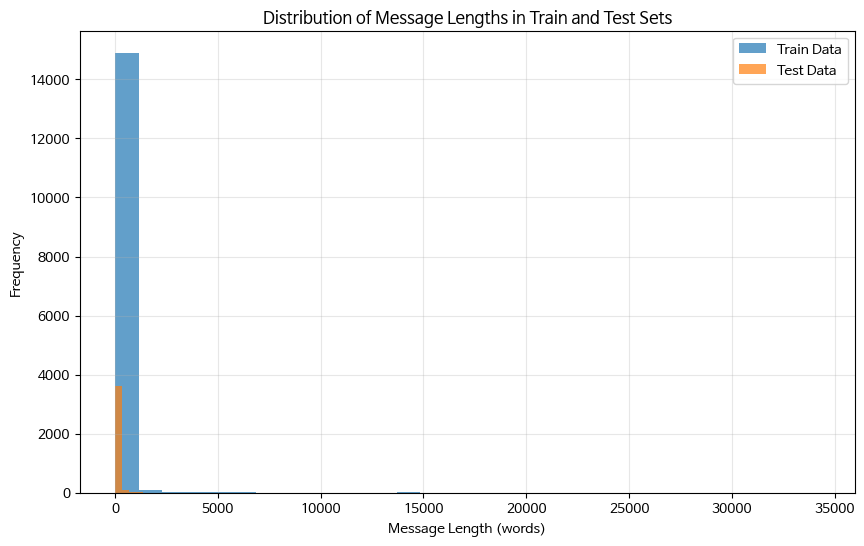

훈련 데이터: 15076
테스트 데이터: 3770


In [13]:
# 토큰화된 데이터를 다시 문자열로 변환 (TF-IDF용)
cleaned_texts = [' '.join(tokens) for tokens in tokenized]

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    cleaned_texts, labels, test_size=0.2, random_state=42, stratify=labels
)

# 메시지 길이 계산
train_lengths = [len(text.split()) for text in X_train]
test_lengths = [len(text.split()) for text in X_test]

# 메시지 길이 분포 시각화


plt.figure(figsize=(10, 6))
plt.hist(train_lengths, bins=30, alpha=0.7, label='Train Data')
plt.hist(test_lengths, bins=30, alpha=0.7, label='Test Data')
plt.xlabel('Message Length (words)')
plt.ylabel('Frequency')
plt.title('Distribution of Message Lengths in Train and Test Sets')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"훈련 데이터: {len(X_train)}")
print(f"테스트 데이터: {len(X_test)}")

In [14]:
# 평균, 최대값, 중간값 계산 및 출력
print("훈련 데이터 평균 길이:", np.mean(train_lengths))
print("훈련 데이터 최대 길이:", np.max(train_lengths))
print("훈련 데이터 95분위수 길이:", np.percentile(train_lengths, 95))

훈련 데이터 평균 길이: 124.40428495622182
훈련 데이터 최대 길이: 34272
훈련 데이터 95분위수 길이: 328.25


In [15]:
print("lens:", len(X_train), len(y_train), len(X_test), len(y_test))  # 모두 일치해야 함

lens: 15076 15076 3770 3770


# 모델링

## 베이스라인 모델 (TF-IDF + LogisticRegression)



In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# TF-IDF + 로지스틱 회귀 파이프라인
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=10000,
        ngram_range=(1,2),
        min_df=2,
        max_df=0.9
    )),
    ('clf', LogisticRegression(
        max_iter=1000,
        random_state=42,
        C=1.0,
        n_jobs=-1
    ))
])

# 모델 학습
print("베이스라인 모델 학습 중...")
pipeline.fit(X_train, y_train)

# 예측 및 평가
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"베이스라인 모델 정확도: {accuracy:.4f}")
print("\n분류 리포트:")
print(classification_report(y_test, y_pred, target_names=target_names))

베이스라인 모델 학습 중...
베이스라인 모델 정확도: 0.7350

분류 리포트:
                          precision    recall  f1-score   support

             alt.atheism       0.60      0.52      0.56       160
           comp.graphics       0.71      0.72      0.72       195
 comp.os.ms-windows.misc       0.71      0.70      0.70       197
comp.sys.ibm.pc.hardware       0.70      0.68      0.69       196
   comp.sys.mac.hardware       0.77      0.71      0.74       193
          comp.windows.x       0.83      0.84      0.84       198
            misc.forsale       0.82      0.77      0.80       195
               rec.autos       0.50      0.80      0.61       198
         rec.motorcycles       0.73      0.68      0.71       199
      rec.sport.baseball       0.83      0.82      0.83       199
        rec.sport.hockey       0.91      0.89      0.90       200
               sci.crypt       0.86      0.78      0.82       198
         sci.electronics       0.67      0.75      0.71       197
                 sci.med    

성능 지표 분석

- 매크로 F1=0.72 vs 정확도=0.74 → 클래스별 편차가 좀 있음(몇몇 약한 클래스가 전체를 끌어내림).

- 잘 나오는 축: hockey(0.90), comp.windows.x(0.84), baseball(0.83), sci.crypt(0.82), sci.med(0.80)

- 약한 축: talk.religion.misc (F1 0.36), alt.atheism (0.56), rec.autos (0.61)

클래스 별 분석

- rec.autos: Precision 0.50 / Recall 0.80 → 실제 autos는 잘 잡지만(재현율↑) 다른 “rec.*”를 autos로 오탐 많이 함.

   - 원인: sale, car, drive 같은 일반어가 forsale/motorcycles에도 흔함.

- talk.religion.misc: Recall 0.26 → 가장 힘듦.

   - 원인: 범주가 모호하고 alt.atheism / soc.religion.christian과 어휘가 겹침. 클래스 경계가 흐림.

- comp.graphics → sci.electronics 오분류 예시: 하드웨어/성능 용어(mhz, bus, card)가 전자공학/하드웨어 문맥으로 더 강하게 학습됨.

- **정치 3개(talk.politics.*)**도 서로 헷갈리기 쉬움. 중동 관련 글이 atheism으로 간 것도 종교/정치 어휘 중첩 때문.

In [17]:
# 샘플 예측 결과 확인
print(f"\n샘플 예측 결과 (처음 5개):")
for i in range(min(5, len(y_test))):
    true_label = target_names[y_test[i]]
    pred_label = target_names[y_pred[i]]
    print(f"실제: {true_label} → 예측: {pred_label}")


샘플 예측 결과 (처음 5개):
실제: comp.graphics → 예측: sci.electronics
실제: talk.religion.misc → 예측: talk.religion.misc
실제: comp.windows.x → 예측: comp.windows.x
실제: rec.autos → 예측: rec.autos
실제: talk.politics.mideast → 예측: alt.atheism


혼동행렬

In [18]:
from sklearn.metrics import confusion_matrix
import pandas as pd
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)
# 가장 많이 헷갈린 페어 Top-10
cm_off = cm.copy(); cm_off[range(len(target_names)), range(len(target_names))] = 0
pairs = []
for i in range(len(target_names)):
    j = cm_off[i].argmax()
    pairs.append((target_names[i], target_names[j], cm_off[i,j]))
sorted(pairs, key=lambda x: -x[2])[:10]


[('talk.religion.misc', 'soc.religion.christian', 33),
 ('rec.motorcycles', 'rec.autos', 23),
 ('alt.atheism', 'soc.religion.christian', 21),
 ('talk.politics.misc', 'talk.politics.guns', 20),
 ('comp.sys.mac.hardware', 'comp.sys.ibm.pc.hardware', 18),
 ('comp.sys.ibm.pc.hardware', 'comp.os.ms-windows.misc', 17),
 ('talk.politics.guns', 'talk.politics.misc', 16),
 ('comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 14),
 ('sci.electronics', 'rec.autos', 13),
 ('comp.windows.x', 'comp.graphics', 11)]

각 클래스의 "대표 단어" 보기 (로지스틱 계수)

In [19]:
import numpy as np
tfidf = pipeline.named_steps['tfidf']
clf = pipeline.named_steps['clf']
feat_names = np.array(tfidf.get_feature_names_out())

for k, cls in enumerate(target_names):
    top = clf.coef_[k].argsort()[-15:][::-1]
    print(f"[{cls}] ", ", ".join(feat_names[top]))


[alt.atheism]  atheist, religion, god, atheism, deletion, islamic, islam, motto, moral, bible, morality, bobby, belief, cheer kent, claim
[comp.graphics]  graphic, image, 3d, file, polygon, animation, format, pov, tiff, vesa, computer, program, viewer, algorithm, xv
[comp.os.ms-windows.misc]  window, windows, file, microsoft, driver, font, cica, nt, win, use, win3, ax ax, mouse, ax, version
[comp.sys.ibm.pc.hardware]  pc, drive, card, monitor, bios, modem, ide, scsi, cpu, computer, gateway, port, irq, motherboard, driver
[comp.sys.mac.hardware]  mac, apple, monitor, quadra, duo, centris, lc, se, drive, powerbook, scsi, price, simms, iisi, lciii
[comp.windows.x]  server, window, motif, widget, xterm, display, x11r5, use, application, sun, xv, user, hi, xlib, mit
[misc.forsale]  sale, offer, sell, include, make offer, ship, 00, condition, shipping, new, interested, email, cd, pay, ticket
[rec.autos]  car, engine, ford, dealer, oil, toyota, auto, mustang, gt, honda, vw, vehicle, wagon, wh

## Word2Vec / fastText 임베딩

In [20]:
from gensim.models import Word2Vec, FastText
import numpy as np

# Word2Vec 모델 학습
w2v_model = Word2Vec(
    tokenized,
    vector_size=200,
    window=5,
    min_count=5,
    workers=4,
    sg=1  # Skip-gram
)

# FastText 모델 학습
fasttext_model = FastText(
    tokenized,
    vector_size=200,
    window=5,
    min_count=5,
    workers=4
)

print("Word2Vec 모델 학습 완료")
print("FastText 모델 학습 완료")

Word2Vec 모델 학습 완료
FastText 모델 학습 완료


## 임베딩 벡터 생성

In [21]:
def get_document_vector(model, tokens):
    """문서의 평균 임베딩 벡터 계산"""
    vectors = []
    for token in tokens:
        if token in model.wv:
            vectors.append(model.wv[token])

    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Split tokenized data using the same indices as the text split
train_indices = train_test_split(
    range(len(tokenized)), labels, test_size=0.2, random_state=42, stratify=labels
)[0]
test_indices = train_test_split(
    range(len(tokenized)), labels, test_size=0.2, random_state=42, stratify=labels
)[1]

tokenized_train = [tokenized[i] for i in train_indices]
tokenized_test = [tokenized[i] for i in test_indices]

# Word2Vec 벡터 생성
X_train_w2v = np.array([get_document_vector(w2v_model, tokens) for tokens in tokenized_train])
X_test_w2v = np.array([get_document_vector(w2v_model, tokens) for tokens in tokenized_test])

# FastText 벡터 생성
X_train_fasttext = np.array([get_document_vector(fasttext_model, tokens) for tokens in tokenized_train])
X_test_fasttext = np.array([get_document_vector(fasttext_model, tokens) for tokens in tokenized_test])

print("Word2Vec vectors generated.")
print("FastText vectors generated.")

Word2Vec vectors generated.
FastText vectors generated.


## PyTorch Dataset/DataLoader 구현

In [22]:
import torch
from torch.utils.data import Dataset, DataLoader

class NewsDataset(Dataset):
    def __init__(self, texts, labels, model, max_len=100):
        self.texts = texts
        self.labels = labels
        self.model = model
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = self.texts[idx]
        label = self.labels[idx]

        # 임베딩 벡터 생성
        vectors = []
        for token in tokens[:self.max_len]:
            if token in self.model.wv:
                vectors.append(self.model.wv[token])
            else:
                vectors.append(np.zeros(self.model.vector_size))

        # 패딩
        while len(vectors) < self.max_len:
            vectors.append(np.zeros(self.model.vector_size))

        return torch.FloatTensor(vectors), torch.LongTensor([label])

## RNN 모델 (LSTM/GRU)

In [23]:
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=2):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                           batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        lstm_out, _ = self.lstm(x)
        # 마지막 시퀀스의 출력 사용
        out = self.dropout(lstm_out[:, -1, :])
        out = self.fc(out)
        return out

## 모델 학습 및 평가

In [24]:
# 하이퍼파라미터
input_size = 200  # Word2Vec/FastText 벡터 크기
hidden_size = 128
num_classes = 20
num_epochs = 10
batch_size = 32

# 모델 초기화
model = RNNClassifier(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# DataLoader 생성
train_dataset = NewsDataset(tokenized_train, y_train, w2v_model)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 학습 루프
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_vectors, batch_labels in train_loader:
        batch_vectors = batch_vectors.to(device)
        batch_labels = batch_labels.squeeze().to(device)

        optimizer.zero_grad()
        outputs = model(batch_vectors)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')

/tmp/ipython-input-285364294.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return torch.FloatTensor(vectors), torch.LongTensor([label])


Epoch [1/10], Loss: 2.7693
Epoch [2/10], Loss: 2.9656
Epoch [3/10], Loss: 2.9739
Epoch [4/10], Loss: 2.6645
Epoch [5/10], Loss: 2.8969
Epoch [6/10], Loss: 2.8329
Epoch [7/10], Loss: 2.6226
Epoch [8/10], Loss: 2.5268
Epoch [9/10], Loss: 2.4227
Epoch [10/10], Loss: 2.3885


# 성능 평가

## 성능 비교 및 분석

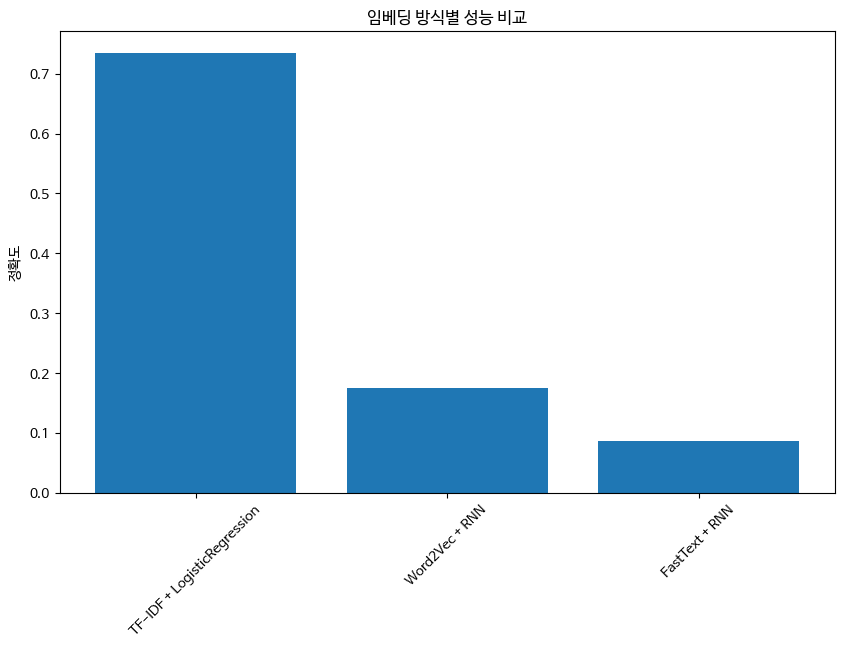

In [25]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pandas as pd
import numpy as np

# Calculate TF-IDF + LogisticRegression score
tfidf_score = accuracy_score(y_test, y_pred)

# Evaluate Word2Vec + RNN
model.eval()
test_dataset_w2v = NewsDataset(tokenized_test, y_test, w2v_model)
test_loader_w2v = DataLoader(test_dataset_w2v, batch_size=batch_size)

y_true_w2v = []
y_pred_w2v = []

with torch.no_grad():
    for batch_vectors, batch_labels in test_loader_w2v:
        batch_vectors = batch_vectors.to(device)
        batch_labels = batch_labels.squeeze().to(device)

        outputs = model(batch_vectors)
        _, predicted = torch.max(outputs.data, 1)

        y_true_w2v.extend(batch_labels.cpu().numpy())
        y_pred_w2v.extend(predicted.cpu().numpy())

w2v_rnn_score = accuracy_score(y_true_w2v, y_pred_w2v)

# Evaluate FastText + RNN
test_dataset_fasttext = NewsDataset(tokenized_test, y_test, fasttext_model)
test_loader_fasttext = DataLoader(test_dataset_fasttext, batch_size=batch_size)

y_true_fasttext = []
y_pred_fasttext = []

with torch.no_grad():
    for batch_vectors, batch_labels in test_loader_fasttext:
        batch_vectors = batch_vectors.to(device)
        batch_labels = batch_labels.squeeze().to(device)

        outputs = model(batch_vectors)
        _, predicted = torch.max(outputs.data, 1)

        y_true_fasttext.extend(batch_labels.cpu().numpy())
        y_pred_fasttext.extend(predicted.cpu().numpy())

fasttext_rnn_score = accuracy_score(y_true_fasttext, y_pred_fasttext)

# 각 임베딩 방식별 성능 비교
results = {
    'TF-IDF + LogisticRegression': tfidf_score,
    'Word2Vec + RNN': w2v_rnn_score,
    'FastText + RNN': fasttext_rnn_score
}

# 결과 시각화
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values())
plt.title('임베딩 방식별 성능 비교')
plt.ylabel('정확도')
plt.xticks(rotation=45)
plt.show()